# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [1]:
from platform import python_version

print(python_version())

3.7.0


In [2]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [3]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**2) Check the shape of images and targets.**

In [4]:
#############
# TO DO 
print(f"x_train shape is {x_train.shape}\nx_test shape is {x_test.shape}\n")
print(f"y_train shape is {y_train.shape}\ny_test shape is {y_test.shape}")
# END TO DO 
#############

x_train shape is (50000, 32, 32, 3)
x_test shape is (10000, 32, 32, 3)

y_train shape is (50000, 1)
y_test shape is (10000, 1)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [5]:
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [6]:
from keras.utils import normalize

To understand the data, these are the RGB values of the pixel in position (5,5) of the first image.

In [7]:
x_train[0, 5, 5, :]

array([131,  84,  42], dtype=uint8)

In [8]:
x_train_norm = normalize(
    x_train, 
    axis=3
)

x_test_norm = normalize(
    x_test, 
    axis=3
)

To understand the data, these are the RGB values of the pixel in position (5,5) of the first image.

In [9]:
x_train[0, 5, 5, :]

array([131,  84,  42], dtype=uint8)

Same pixel, after normalization.

In [10]:
x_train_norm[0, 5, 5, :]

array([0.81272452, 0.52113634, 0.26056817])

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [11]:
y_train = to_categorical(
    y_train, 
    num_classes=len(labels)
)

y_test = to_categorical(
    y_test, 
    num_classes=len(labels)
) 

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

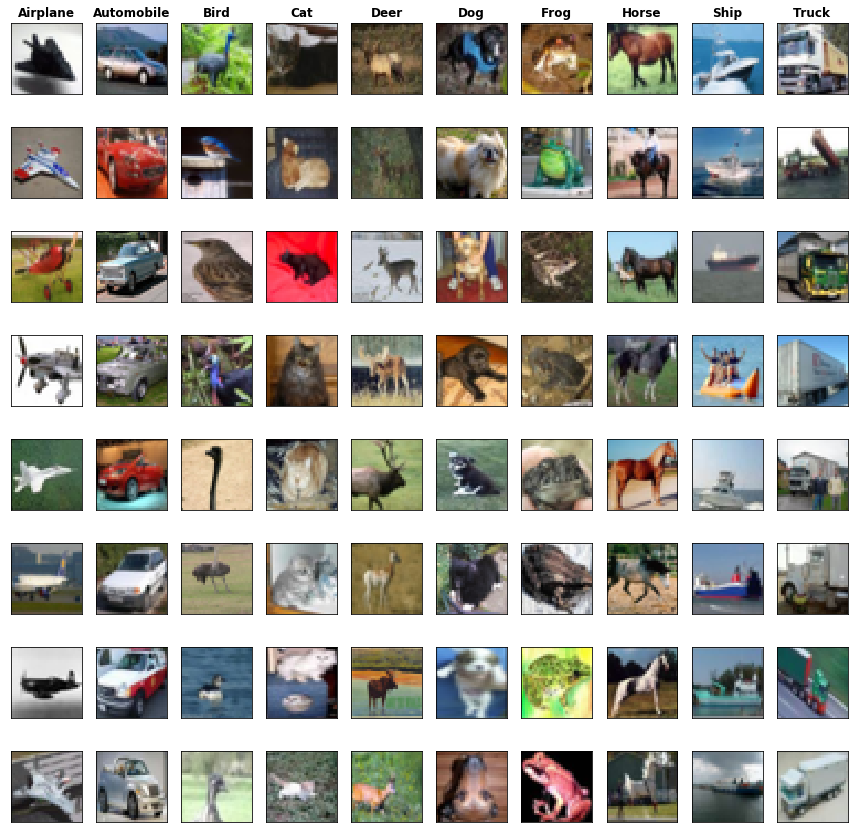

In [12]:
limit = 80
i = 1
count = 0
columns = len(labels)
rows = 8
num_cat = np.repeat(0, columns)

fig=plt.figure(figsize=(15, 15))


while count < limit:
    index_image = i - 1
    category, = np.where(y_train[index_image] == 1.)[0]
    if num_cat[category] < 8:
        location = columns * num_cat[category] + category + 1
        sp = fig.add_subplot(rows, columns, location, xticks= [], yticks=[])
        if(num_cat[category] == 0):
            sp.set_title(labels[category].title(),fontweight="bold")
        num_cat[category] = num_cat[category] + 1
        plt.imshow(x_train[index_image, :])
        count += 1
    i += 1

The following code summarizes the previous operations. 

In [13]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    labels = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    x_train_norm = normalize(x_train, axis=3)
    x_test_norm = normalize(x_test, axis=3)
    
    y_train = to_categorical(y_train, num_classes=len(labels), dtype=int)
    y_test  = to_categorical(y_test, num_classes=len(labels), dtype=int)

    return x_train_norm, y_train, x_test_norm, y_test, labels


x_train_norm, y_train, x_test_norm, y_test, labels = load_cifar_data()

In [104]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    
    fig, axs = plt.subplots(n, len(labels))
    fig.set_figheight(15)
    fig.set_figwidth(15)
#     plt.subplots_adjust(wspace=0.5, hspace=10)
    
    for j in labels.keys():
        imgs = images[categories[:,j]==1][:n]
        for i in range(n):
            axs[i,j].imshow(imgs[i])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
    
    for ax, col in zip(axs[0], labels.values()):
        ax.set_title(col.title(), fontweight="bold")
    #fig
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

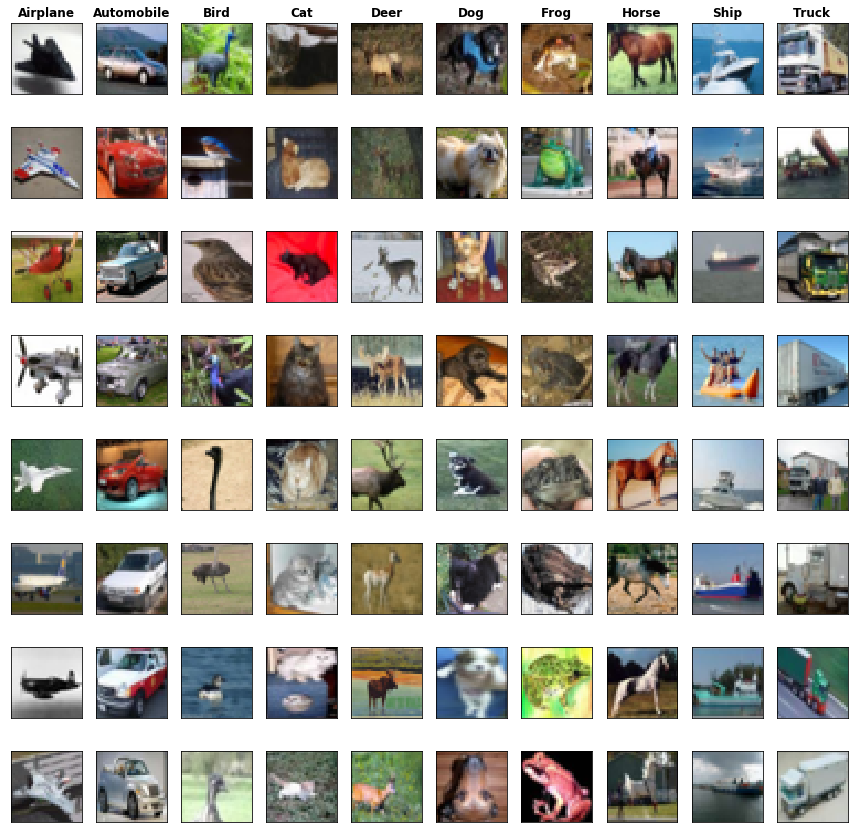

In [105]:
show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)

In [15]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    # Indexes associated to the first n images
    categories_df = pd.DataFrame(categories)
    indexes = []
    for j in np.arange(categories_df.shape[1]):
        mask = categories_df.iloc[:,j] == 1
        indexes.append(categories_df[mask].index[0:n])
    # nx10 dataframe with the first n images for each class
    firstn_images = pd.DataFrame(np.array(indexes).T)
    # Printing our images with their title
    fig, ax = plt.subplots(n, 9, sharex='col', sharey='row', figsize=(8,8))
    for k in np.arange(firstn_images.shape[0]):
        for j in np.arange(firstn_iddmages.shape[1]-1):
            i = firstn_images.iloc[k,j]
            ax[k,j].imshow(x_train[i])
        cols = labels
        for axis, col in zip(ax[0], cols):
                axis.set_title(col)
    #fig
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

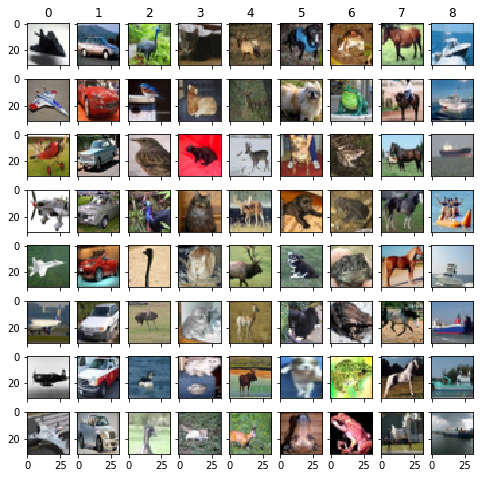

In [37]:
show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [21]:
def dense_model(input_shape, num_classes):
    
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='linear')
    ])
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [22]:
model = dense_model(x_train.shape[1:], len(labels))
model.build()

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
____________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [24]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    
    cb = EarlyStopping(monitor='accuracy', patience=2)
    
    model.fit(
        x,
        y, 
        batch_size=batch_size, 
        epochs=epochs, 
        callbacks=[cb], 
        validation_split=0.2)
    
    return model

In [25]:
ret = train_model(model, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 51s 1ms/step - loss: 9.6554 - accuracy: 0.1005 - val_loss: 9.6628 - val_accuracy: 0.0977
Epoch 2/10
29792/40000 [=====================>........] - ETA: 12s - loss: 9.6643 - accuracy: 0.1022

KeyboardInterrupt: 

**11) Plot several images with their predictions. Any comment?**

In [44]:
pred = ret.predict(x_test_norm).argmax(axis = -1) # to get prob

Our model assigns all images to label 5

In [45]:
np.unique(pred)

array([0, 2])

In [107]:
def plot_n_first_pred(pred, n=20):
    col_legend = ['red', 'green']
    fig=plt.figure(figsize=(n, n))
    for i in range(n):
        sp = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        cond = int(pred[i] == y_test[i].argmax())
        col = col_legend[cond]
        sp.set_title(labels[pred[i]].title(),fontweight="bold", color=col)
        plt.imshow(x_test[i, :], )

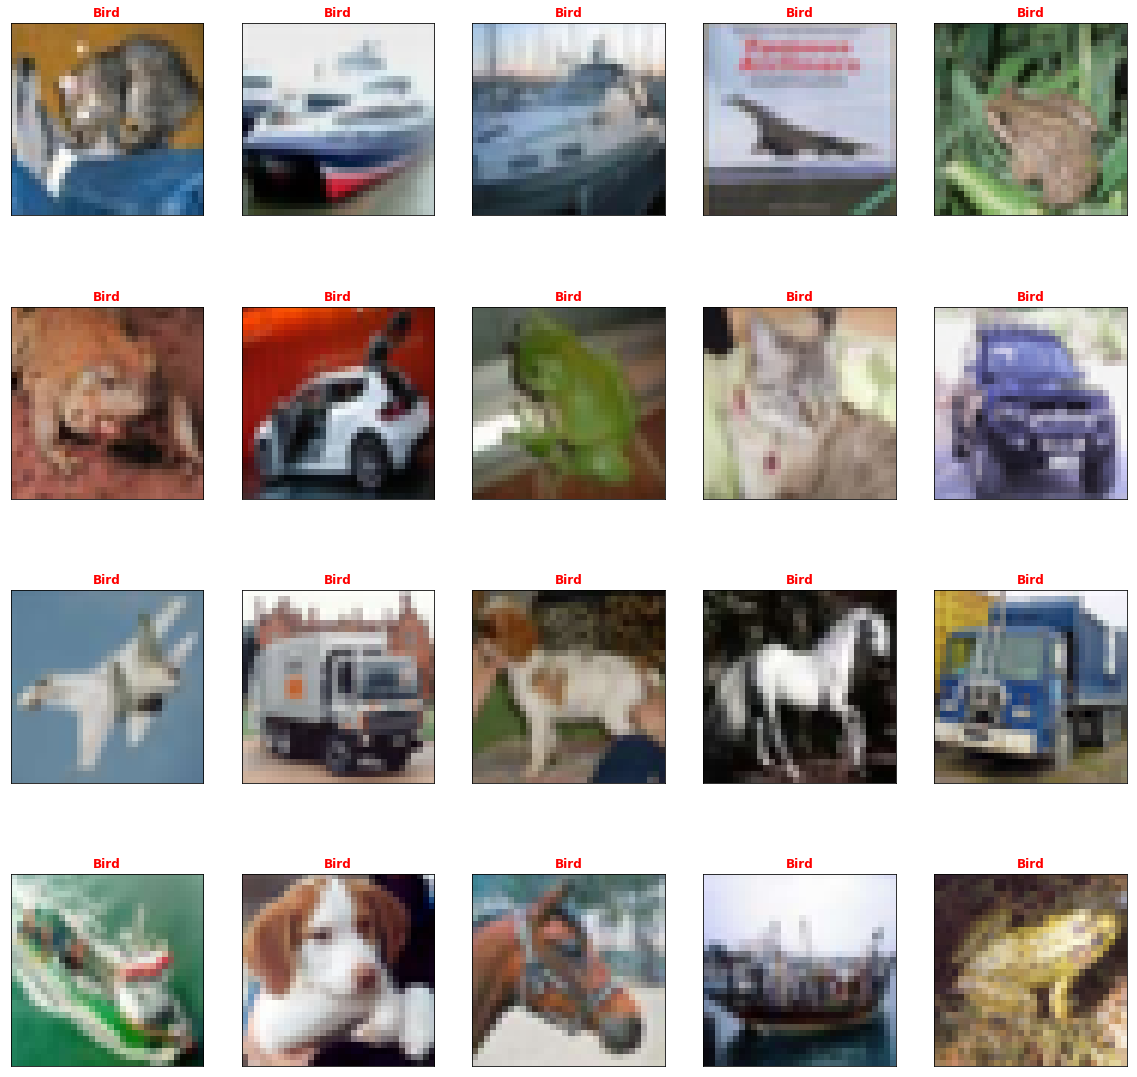

In [47]:
plot_n_first_pred(pred, 20)

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [121]:
def cnn_model(input_shape, num_classes):
    
    model = Sequential([
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='same',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),
            MaxPooling2D(2),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),       
            MaxPooling2D(2),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )    
    
    return model



model = cnn_model(x_train.shape[1:], 10)

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

In [8]:
######################
# TO DO

# END TO DO 
######################

In [122]:
model.build()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1600)             

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [124]:
cnn = train_model(model, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 52s 1ms/step - loss: 2.1130 - accuracy: 0.2108 - val_loss: 1.9314 - val_accuracy: 0.2887
Epoch 2/10
40000/40000 [==============================] - 56s 1ms/step - loss: 1.8753 - accuracy: 0.3169 - val_loss: 1.8229 - val_accuracy: 0.3380
Epoch 3/10
40000/40000 [==============================] - 53s 1ms/step - loss: 1.7409 - accuracy: 0.3710 - val_loss: 1.7490 - val_accuracy: 0.3665
Epoch 4/10
40000/40000 [==============================] - 54s 1ms/step - loss: 1.6314 - accuracy: 0.4198 - val_loss: 1.6356 - val_accuracy: 0.4208
Epoch 5/10
40000/40000 [==============================] - 55s 1ms/step - loss: 1.5468 - accuracy: 0.4511 - val_loss: 1.5663 - val_accuracy: 0.4474
Epoch 6/10
40000/40000 [==============================] - 55s 1ms/step - loss: 1.4803 - accuracy: 0.4766 - val_loss: 1.5204 - val_accuracy: 0.4649
Epoch 7/10
40000/40000 [==============================] - 56s 1ms/st

In [10]:
######################
# TO DO


# END TO DO 
######################

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [11]:
######################
# TO DO

# END TO DO 
######################

In [12]:
######################
# TO DO

# END TO DO 
######################

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

The phenomenon is due to overfitting. Our model is putting too much emphasis on the training set, resulting in failing to generalize and accurately predicting examples in the test set.

In [34]:
def cnn_dropout(input_shape, num_classes):
    
    model = Sequential([
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='same',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),
            Dropout(
                rate=0.25, 
                noise_shape=None, 
                seed=None
            ),
            MaxPooling2D(2),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),       
            MaxPooling2D(2),
            Dropout(
                rate=0.25, 
                noise_shape=None, 
                seed=None
            ),        
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(
                rate=0.25, 
                noise_shape=None, 
                seed=None
            ),        
            Dense(10, activation='softmax')
        ])
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )    
    
    return model

In [35]:
model = cnn_dropout(x_train.shape[1:], 10)
model.build()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)         

In [36]:
cnn_dropout = train_model(model, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 61s 2ms/step - loss: 2.1504 - accuracy: 0.1899 - val_loss: 2.0398 - val_accuracy: 0.2577
Epoch 2/10
40000/40000 [==============================] - 62s 2ms/step - loss: 1.9513 - accuracy: 0.2824 - val_loss: 1.8716 - val_accuracy: 0.3200
Epoch 3/10
40000/40000 [==============================] - 61s 2ms/step - loss: 1.8398 - accuracy: 0.3272 - val_loss: 1.7816 - val_accuracy: 0.3666
Epoch 4/10
40000/40000 [==============================] - 63s 2ms/step - loss: 1.7350 - accuracy: 0.3737 - val_loss: 1.7013 - val_accuracy: 0.3934
Epoch 5/10
40000/40000 [==============================] - 67s 2ms/step - loss: 1.6593 - accuracy: 0.4021 - val_loss: 1.6639 - val_accuracy: 0.4215
Epoch 6/10
40000/40000 [==============================] - 68s 2ms/step - loss: 1.6031 - accuracy: 0.4234 - val_loss: 1.6427 - val_accuracy: 0.4213
Epoch 7/10
40000/40000 [==============================] - 67s 2ms/st

Adding dropout layers slightly increases the validation accuracy, while at the same time it decreases the train accuracy. Important to notice, the train accuracy is lower than the validation accuracy in every iteration. However, the two numbers are close to one another. 

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [24]:
def cnn_model_batchnorm(input_shape, num_classes):
    
    model = Sequential([
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='same',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),
            BatchNormalization(),
            Dropout(
                rate=0.25, 
                noise_shape=None, 
                seed=None
            ),
            MaxPooling2D(2),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu',
                input_shape=input_shape
            ),       
            MaxPooling2D(2),
            BatchNormalization(),
            Dropout(
                rate=0.25, 
                noise_shape=None, 
                seed=None
            ),        
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(
                rate=0.25, 
                noise_shape=None, 
                seed=None
            ),        
            Dense(10, activation='softmax')
        ])
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )    
    
    return model



model = cnn_model_batchnorm(x_train.shape[1:], 10)

In [25]:
cnn_model_batchnorm = train_model(model, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 79s 2ms/step - loss: 2.0117 - accuracy: 0.3167 - val_loss: 2.9291 - val_accuracy: 0.1758
Epoch 2/10
40000/40000 [==============================] - 80s 2ms/step - loss: 1.6415 - accuracy: 0.4166 - val_loss: 2.0788 - val_accuracy: 0.3092
Epoch 3/10
40000/40000 [==============================] - 77s 2ms/step - loss: 1.5293 - accuracy: 0.4600 - val_loss: 2.8245 - val_accuracy: 0.2343
Epoch 4/10
40000/40000 [==============================] - 78s 2ms/step - loss: 1.4409 - accuracy: 0.4914 - val_loss: 2.9029 - val_accuracy: 0.1998
Epoch 5/10
40000/40000 [==============================] - 80s 2ms/step - loss: 1.3859 - accuracy: 0.5099 - val_loss: 3.2217 - val_accuracy: 0.2195
Epoch 6/10
40000/40000 [==============================] - 82s 2ms/step - loss: 1.3348 - accuracy: 0.5278 - val_loss: 2.0280 - val_accuracy: 0.3257
Epoch 7/10
40000/40000 [==============================] - 91s 2ms/st

Adding a batch normalization layer before each dropout layer, results in a model which is highly overfitting the training data. The validation accuracy, despite being lower than before, is also oscillating between 0.18 and 0.35.

The model is then very sensitivity to noise and results in describing random error. instead of the underlying relationships.

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

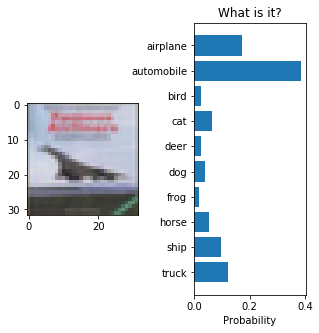

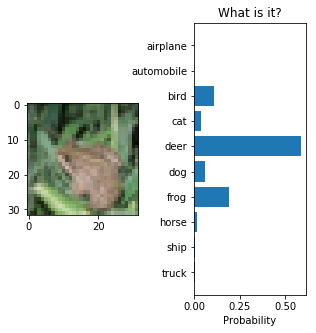

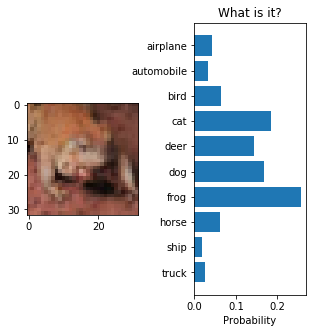

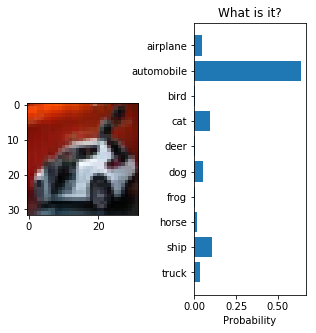

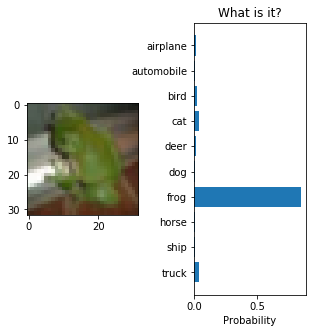

In [60]:
def predict(model, x, labels, file_name=None):
    
    x_norm = normalize(
        x, 
        axis=3
    )
    
    pred = cnn_dropout.predict(x_norm)
    for i in range(len(pred)):
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_figheight(5,5)
        fig.set_figwidth(5,5)
        plt.subplots_adjust(wspace=0.5, hspace=10)
        
        ax1.imshow(x[i,:,:,:])
        
        y_pos = np.arange(len(labels))
        ax2.barh(y_pos, pred[i], align='center')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(labels.values())
        ax2.invert_yaxis()
        ax2.set_xlabel('Probability')
        ax2.set_title('What is it?')
    
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

# predict(cnn_dropout, x_test[3:8,:,:,:], labels, file_name="predictions.png")

predict(cnn_dropout, x_test[3:8,:,:,:], labels)

Let's have a look at how the cnn_dropout model predicts.

It looks like there are troubles classifying automobiles.

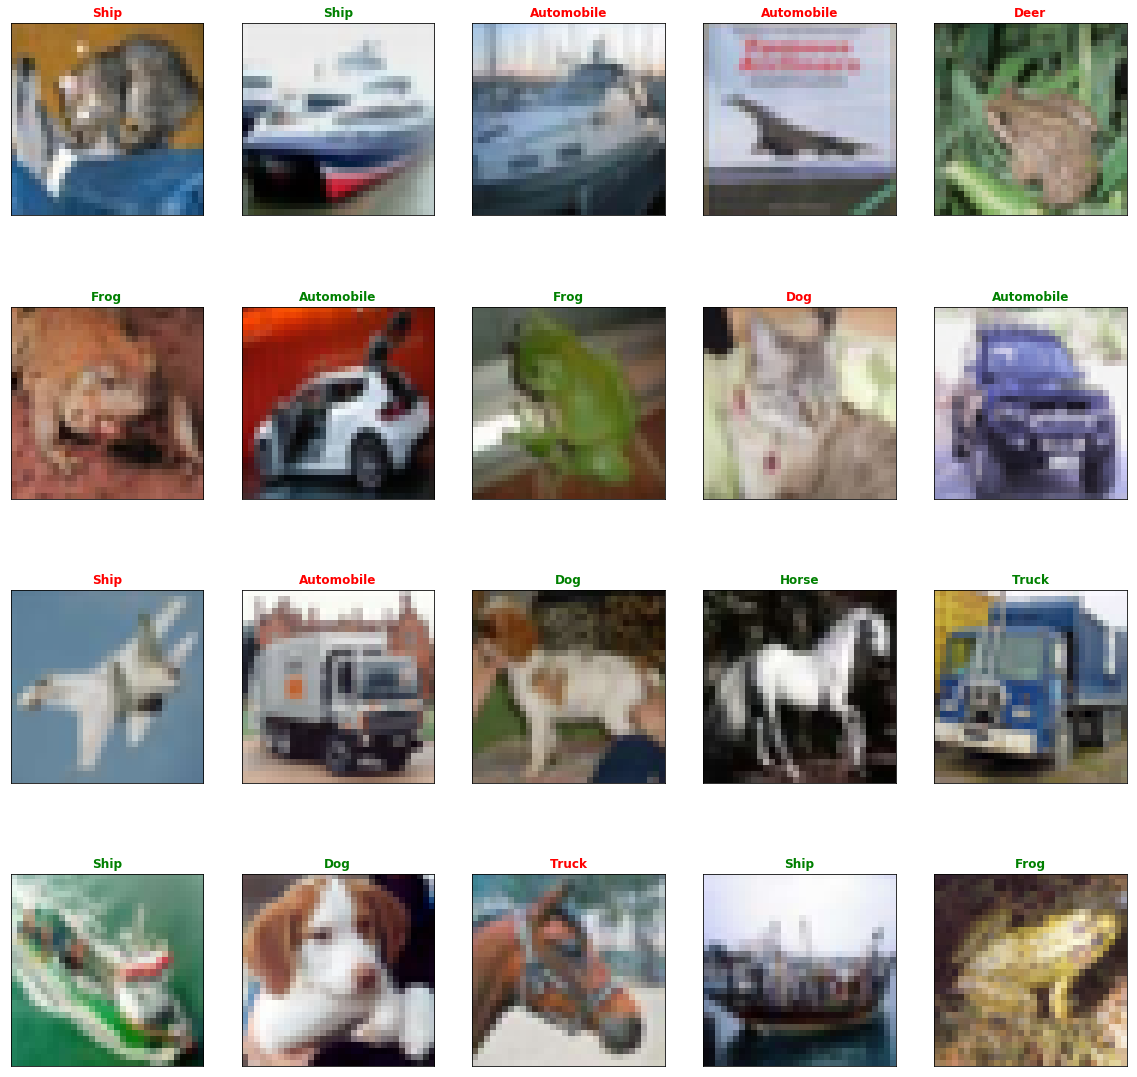

In [112]:
pred = cnn_dropout.predict(x_test_norm).argmax(axis = -1)
plot_n_first_pred(pred)

---

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [17]:
######################
# TO DO

...


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    ...
    
    




# END TO DO 
######################

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks (Bonus !)

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [18]:
###########################
# TO DO 

# END TO DO 
##################

In [19]:
###########################
# TO DO 

# END TO DO 
##################

In [20]:
###########################
# TO DO 

# END TO DO 
##################

In [21]:
##################
# TO DO 


# END TO DO 
##################